# Imports

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import random
import os
import time
from datetime import datetime
from tqdm import tqdm
import json
import wandb

from IPython import get_ipython
get_ipython().kernel.do_one_iteration = lambda: None


/home/blozerx/venvs/smai-env/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/blozerx/venvs/smai-env/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Ann

# Loading Images

Image shape: (256, 256)
Image dtype: uint8


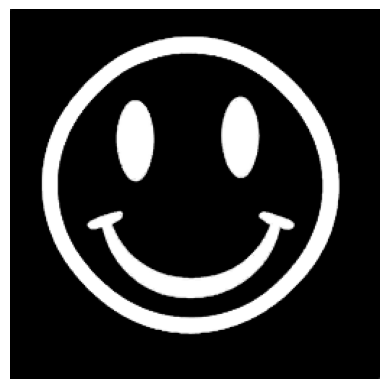

In [3]:
# Load and display the smiley image
image_path = 'Dataset/Q2/smiley.png'
image_smiley = Image.open(image_path)
image_array_smiley = np.array(image_smiley)

print(f"Image shape: {image_array_smiley.shape}")
print(f"Image dtype: {image_array_smiley.dtype}")

plt.imshow(image_smiley)
plt.axis('off')
plt.show()

Image shape: (256, 256, 3)
Image dtype: uint8


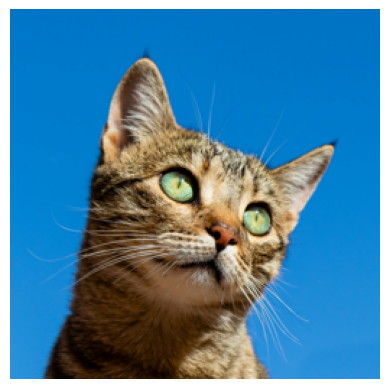

In [5]:
# Load and display the cat image
image_path = 'Dataset/Q2/cat.jpg'
image_cat = Image.open(image_path)
image_cat = image_cat.resize((256, 256))
image_array_cat = np.array(image_cat)

print(f"Image shape: {image_array_cat.shape}")
print(f"Image dtype: {image_array_cat.dtype}")

plt.imshow(image_cat)
plt.axis('off')
plt.show()

# Feature Expansion

In [6]:
def get_raw(coords):
    return coords

def get_polynomial(coords, order=5):
    x, y = coords[:, 0], coords[:, 1]
    features = [np.ones_like(x)]  # bias term
    
    # Generate polynomial terms
    raw_features = []
    for i in range(1, order + 1):
        for j in range(i + 1):
            power_x = i - j
            power_y = j
            feature = (x ** power_x) * (y ** power_y)
            raw_features.append(feature)
    
    if len(raw_features) > 0:
        # Stack all polynomial features (excluding bias)
        poly_features = np.stack(raw_features, axis=1)
        
        # Normalize polynomial features to prevent exploding values
        # Use min-max normalization to keep values in reasonable range
        poly_min = np.min(poly_features, axis=0, keepdims=True)
        poly_max = np.max(poly_features, axis=0, keepdims=True)
        poly_range = poly_max - poly_min
        # Avoid division by zero
        poly_range = np.where(poly_range == 0, 1, poly_range)
        poly_normalized = (poly_features - poly_min) / poly_range
        
        # Combine bias term with normalized polynomial features
        features_normalized = np.concatenate([
            features[0].reshape(-1, 1),  # bias term
            poly_normalized
        ], axis=1)
    else:
        features_normalized = np.stack(features, axis=1)
    
    return features_normalized

def get_fourier(coords, freq=10):
    x, y = coords[:, 0], coords[:, 1]
    features = [np.ones_like(x)]  # bias term
        
    # Add sine and cosine features for x coordinate
    for f in range(1, freq + 1):
        features.append(np.sin(2 * np.pi * f * x))
        features.append(np.cos(2 * np.pi * f * x))
        
    # Add sine and cosine features for y coordinate
    for f in range(1, freq + 1):
        features.append(np.sin(2 * np.pi * f * y))
        features.append(np.cos(2 * np.pi * f * y))

    for f1 in range(1, min(freq + 1, 4)):  # Limit mixed terms to avoid explosion
        for f2 in range(1, min(freq + 1, 4)):
            freq_x = 2 * np.pi * f1
            freq_y = 2 * np.pi * f2
            features.append(np.sin(freq_x * x) * np.sin(freq_y * y))
            features.append(np.cos(freq_x * x) * np.cos(freq_y * y))
        
    return np.stack(features, axis=1)

    

# Dataloader

In [7]:
class Modular_Dataloader(Dataset):
    """
    Modular dataloader for image-to-coordinate mapping with different feature expansions
    """

    def __init__(self, image, image_type, method, order=5, freq=10):
        """
        Initialize the modular dataloader
        """
        self.image_array = image
        self.image_type = image_type
        self.method = method
        self.order = order
        self.freq = freq
        
        # Normalize pixel values to [0, 1]
        if self.image_array.max() > 1.0:
            self.image_array = self.image_array / 255.0
        
        self.height, self.width = self.image_array.shape[:2]
        
        # Generate normalized coordinates
        self.coords = self._generate_coordinates()
        
        # Apply feature expansion and normalization
        self.features = self._apply_feature_expansion()
        
        # Prepare targets
        self.targets = self._prepare_targets()
        
        print(f"Loaded image: {self.width}x{self.height}")
        print(f"Image type: {image_type}")
        print(f"Method: {method}")
        print(f"Feature dimension: {self.features.shape[1]}")
        if method == "Polynomial":
            print(f"Polynomial order: {order}")
        elif method == "Fourier":
            print(f"Fourier frequencies: {freq}")
        
    def _generate_coordinates(self):
        """Generate normalized coordinates [0, 1] for all pixels"""
        coords = []
        for i in range(self.height):
            for j in range(self.width):
                # Normalize coordinates to [0, 1]
                x = j / (self.width - 1) if self.width > 1 else 0
                y = i / (self.height - 1) if self.height > 1 else 0
                coords.append([x, y])
        return np.array(coords, dtype=np.float32)
    
    def _apply_feature_expansion(self):
        """Apply the specified feature expansion method with proper normalization"""
        
        if self.method == "Raw":
            features = get_raw(self.coords)
            
        elif self.method == "Polynomial":
            features = get_polynomial(self.coords, order=self.order)
            
        elif self.method == "Fourier":
            # Fourier features with proper coordinate scaling
            features = get_fourier(self.coords, freq=self.freq)
        
        return features.astype(np.float32)
    
    def _prepare_targets(self):
        """Prepare target values (pixel intensities)"""
        if self.image_type == 'Gray':
            # Grayscale: flatten the 2D array
            targets = self.image_array.flatten().reshape(-1, 1)
        else:
            # RGB: reshape to (num_pixels, 3)
            targets = self.image_array.reshape(-1, 3)
        
        return targets.astype(np.float32)
    
    def __len__(self):
        """Return the total number of pixels"""
        return len(self.features)
    
    def __getitem__(self, idx):
        """Get a sample at the given index"""
        return self.features[idx], self.targets[idx]
    
    def get_feature_names(self):
        """Get descriptive names for features (useful for debugging)"""
        if self.method == "Raw":
            return ['x', 'y']
        elif self.method == "Polynomial":
            names = ['bias']
            for i in range(1, self.order + 1):
                for j in range(i + 1):
                    power_x = i - j
                    power_y = j
                    names.append(f'x^{power_x}*y^{power_y}')
            return names
        elif self.method == "Fourier":
            names = ['bias']
            for f in range(1, self.freq + 1):
                names.extend([f'sin({f}*2π*x)', f'cos({f}*2π*x)'])
            for f in range(1, self.freq + 1):
                names.extend([f'sin({f}*2π*y)', f'cos({f}*2π*y)'])
            # Add mixed terms
            for f1 in range(1, min(self.freq + 1, 4)):
                for f2 in range(1, min(self.freq + 1, 4)):
                    names.extend([f'sin({f1}*2π*x)*sin({f2}*2π*y)', 
                                f'cos({f1}*2π*x)*cos({f2}*2π*y)'])
            return names
    
    def get_statistics(self):
        """Get statistics about the features and targets"""
        return {
            'feature_shape': self.features.shape,
            'target_shape': self.targets.shape,
            'feature_mean': np.mean(self.features, axis=0),
            'feature_std': np.std(self.features, axis=0),
            'feature_min': np.min(self.features, axis=0),
            'feature_max': np.max(self.features, axis=0),
            'target_mean': np.mean(self.targets, axis=0),
            'target_std': np.std(self.targets, axis=0),
            'target_min': np.min(self.targets, axis=0),
            'target_max': np.max(self.targets, axis=0)
        }

In [8]:
class ReLU:
    """ReLU activation function"""
    
    def forward(self, x):
        """Forward pass: f(x) = max(0, x)"""
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        """Backward pass: f'(x) = 1 if x > 0, else 0"""
        return grad_output * (self.input > 0)

class Tanh:
    """Tanh activation function"""
    
    def forward(self, x):
        """Forward pass: f(x) = tanh(x)"""
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad_output):
        """Backward pass: f'(x) = 1 - tanh²(x)"""
        return grad_output * (1 - self.output ** 2)

class Sigmoid:
    """Sigmoid activation function"""
    
    def forward(self, x):
        """Forward pass: f(x) = 1 / (1 + exp(-x))"""
        # Clip x to prevent overflow
        x_clipped = np.clip(x, -500, 500)
        self.output = 1 / (1 + np.exp(-x_clipped))
        return self.output
    
    def backward(self, grad_output):
        """Backward pass: f'(x) = sigmoid(x) * (1 - sigmoid(x))"""
        return grad_output * self.output * (1 - self.output)

class Identity:
    """Identity activation function (no activation)"""
    
    def forward(self, x):
        """Forward pass: f(x) = x"""
        return x
    
    def backward(self, grad_output):
        """Backward pass: f'(x) = 1"""
        return grad_output


class Linear:
    """Linear (fully connected) layer with optional activation function"""
    
    def __init__(self, input_width, output_width, activation=Identity()):
        """
        Initialize linear layer
        """
        self.input_width = input_width
        self.output_width = output_width
        self.activation = activation
        
        # Initialize weights and biases using Xavier/Glorot initialization
        self.weights = np.random.randn(input_width, output_width) * np.sqrt(2.0 / input_width)
        self.biases = np.zeros(output_width)
        
        # Initialize cumulative gradients
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)
        
        # Store data for backward pass
        self.input = None
        self.linear_output = None
        self.output = None
    
    def forward(self, x):
        """
        Forward pass through the linear layer
        """
        self.input = x
        
        # Linear transformation: y = xW + b
        self.linear_output = np.dot(x, self.weights) + self.biases
        
        # Apply activation function
        self.output = self.activation.forward(self.linear_output)
        
        return self.output
    
    def backward(self, grad_output):
        """
        Backward pass through the linear layer
        """
        # Gradient through activation function
        grad_activation = self.activation.backward(grad_output)
        
        # Gradients with respect to weights and biases
        if len(self.input.shape) == 1:
            # Single sample
            self.grad_weights += np.outer(self.input, grad_activation)
            self.grad_biases += grad_activation
        else:
            # Batch of samples
            self.grad_weights += np.dot(self.input.T, grad_activation)
            self.grad_biases += np.sum(grad_activation, axis=0)
        
        # Gradient with respect to input
        grad_input = np.dot(grad_activation, self.weights.T)
        
        return grad_input
    
    def zero_grad(self):
        """Reset accumulated gradients to zero"""
        self.grad_weights.fill(0)
        self.grad_biases.fill(0)
    
    def update(self, learning_rate):
        """Update parameters using accumulated gradients"""
        self.weights -= learning_rate * self.grad_weights
        self.biases -= learning_rate * self.grad_biases


class MSELoss:
    """Mean Squared Error loss function"""
    
    def forward(self, y_pred, y_true):
        """
        Compute MSE loss
        """
        self.y_pred = y_pred
        self.y_true = y_true
        
        # MSE = (1/n) * sum((y_pred - y_true)^2)
        loss = np.mean((y_pred - y_true) ** 2)
        return loss
    
    def backward(self):
        """
        Compute gradient of MSE loss
        """
        # d(MSE)/dy_pred = 2 * (y_pred - y_true) / n
        n = len(self.y_pred) if len(self.y_pred.shape) > 0 else 1
        return 2 * (self.y_pred - self.y_true) / n

class BCELoss:
    """Binary Cross Entropy loss function"""
    
    def forward(self, y_pred, y_true):
        """
        Compute BCE loss
        """
        self.y_pred = y_pred
        self.y_true = y_true
        
        # Clip predictions to prevent log(0)
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        self.y_pred_clipped = y_pred_clipped
        
        # BCE = -mean(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        loss = -np.mean(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        return loss
    
    def backward(self):
        """
        Compute gradient of BCE loss
        """
        # d(BCE)/dy_pred = -(y_true / y_pred - (1 - y_true) / (1 - y_pred)) / n
        n = len(self.y_pred) if len(self.y_pred.shape) > 0 else 1
        grad = -(self.y_true / self.y_pred_clipped - (1 - self.y_true) / (1 - self.y_pred_clipped)) / n
        return grad


class Model:
    """Neural network model class"""
    
    def __init__(self, layers, loss_fn, learning_rate=0.001):
        """
        Initialize model
        """
        self.layers = layers
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        
        # Training metrics
        self.train_losses = []
        self.samples_seen = []
    
    def forward(self, x):
        """
        Forward pass through all layers
        """
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, grad_output):
        """
        Backward pass through all layers
        """
        grad = grad_output
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def train(self, x, y):
        """
        Perform forward pass, compute loss, and backpropagate
        """
        # Forward pass
        y_pred = self.forward(x)
        
        # Compute loss
        loss = self.loss_fn.forward(y_pred, y)
        
        # Backward pass
        grad_loss = self.loss_fn.backward()
        self.backward(grad_loss)
        
        return loss
    
    def zero_grad(self):
        """Reset gradients in all layers"""
        for layer in self.layers:
            layer.zero_grad()
    
    def update(self):
        """Update parameters and reset gradients"""
        for layer in self.layers:
            layer.update(self.learning_rate)
        self.zero_grad()
    
    def predict(self, x):
        """
        Make predictions without gradient computation
        """
        return self.forward(x)
    
    def save_to(self, path):
        """
        Save model parameters to file
        """
        params = {}
        for i, layer in enumerate(self.layers):
            params[f'layer_{i}_weights'] = layer.weights
            params[f'layer_{i}_biases'] = layer.biases
        
        np.savez(path, **params)
        print(f"Model saved to {path}")
    
    def load_from(self, path):
        """
        Load model parameters from file
        """
        try:
            params = np.load(path)
            
            # Check if architecture matches
            for i, layer in enumerate(self.layers):
                weight_key = f'layer_{i}_weights'
                bias_key = f'layer_{i}_biases'
                
                if weight_key not in params or bias_key not in params:
                    raise ValueError(f"Missing parameters for layer {i}")
                
                saved_weights = params[weight_key]
                saved_biases = params[bias_key]
                
                if saved_weights.shape != layer.weights.shape:
                    raise ValueError(f"Weight shape mismatch for layer {i}: "
                                   f"expected {layer.weights.shape}, got {saved_weights.shape}")
                
                if saved_biases.shape != layer.biases.shape:
                    raise ValueError(f"Bias shape mismatch for layer {i}: "
                                   f"expected {layer.biases.shape}, got {saved_biases.shape}")
                
                # Load parameters
                layer.weights = saved_weights.copy()
                layer.biases = saved_biases.copy()
            
            print(f"Model loaded from {path}")
            
        except Exception as e:
            raise RuntimeError(f"Error loading model: {e}")

# Training of Feature Mappings

In [9]:
def reconstruct_image(model, dataset, plot, title="Reconstructed Image"):
    """
    Reconstruct the full image using the trained model
    """
    # FIXED: Use the processed features, not raw coordinates
    # This is crucial for Polynomial and Fourier methods
    all_features = dataset.features
    
    # Make predictions
    predictions = model.predict(all_features)
    
    # Reshape predictions back to image shape
    if dataset.image_type == "Gray":
        reconstructed = predictions.reshape(dataset.height, dataset.width)
    else:
        reconstructed = predictions.reshape(dataset.height, dataset.width, 3)
    
    # Clip values to [0, 1] range
    reconstructed = np.clip(reconstructed, 0, 1)
    # Create directory for saving images if it doesn't exist
    if plot:
        os.makedirs("saved_images", exist_ok=True)
            
        # Plot the reconstruction
        fig, ax = plt.subplots(figsize=(8, 6))
        if dataset.image_type == "Gray":
            ax.imshow(reconstructed, cmap='gray')
        else:
            ax.imshow(reconstructed)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        
        # Save the complete figure (including title)
        timestamp = datetime.now().strftime("%H%M%S")
        image_filename = f"saved_images/reconstruction_{timestamp}.png"
        plt.savefig(image_filename, dpi=150, bbox_inches='tight')
        plt.close()
    
    return reconstructed

def train_and_evaluate_method(image_array, image_type, method, params, epochs, 
                             architecture, learning_rate, 
                             batch_size, save_epochs=None):
    """
    Train and evaluate a specific method with given parameters
    """
    print(f"\nTraining {method} with parameters: {params}")
    print("-" * 50)
    
    # Create dataset
    if method == "Raw":
        dataset = Modular_Dataloader(image_array, image_type, method)
    elif method == "Polynomial":
        dataset = Modular_Dataloader(image_array, image_type, method, order=params)
    elif method == "Fourier":
        dataset = Modular_Dataloader(image_array, image_type, method, freq=params)
    
    # Get input dimension
    input_dim = dataset.features.shape[1]
    output_dim = 1 if image_type == "Gray" else 3
    
    # Create model with consistent architecture
    layers = []
    prev_dim = input_dim
    for hidden_dim in architecture:
        layers.append(Linear(prev_dim, hidden_dim, ReLU()))
        prev_dim = hidden_dim

    layers.append(Linear(prev_dim, output_dim, Identity()))
    
    # FIXED: Use MSELoss for regression, not BCELoss
    model = Model(layers, MSELoss(), learning_rate)
    
    # Count total parameters
    total_params = sum(layer.weights.size + layer.biases.size for layer in layers)
    
    print(f"Input features: {input_dim}")
    print(f"Total parameters: {total_params}")
    
    # Training
    start_time = time.time()
    
    # Custom training loop to save images at specific epochs
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    epoch_losses = []
    samples=[0]
    saved_images = {}
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_samples = 0
        
        for batch_idx, (features_batch, targets_batch) in enumerate(dataloader):
            x = features_batch.numpy()
            y = targets_batch.numpy()
            
            if len(y.shape) == 1:
                y = y.reshape(-1, 1)
            
            loss = model.train(x, y)
            epoch_loss += loss * len(x)
            epoch_samples += len(x)
            model.update()
        
        avg_epoch_loss = epoch_loss / epoch_samples
        epoch_losses.append(avg_epoch_loss)
        new = samples[-1] + epoch_samples
        samples.append(new)
        
        # Save image at specified epochs
        if save_epochs and (epoch + 1) in save_epochs:
            reconstructed = reconstruct_image(model, dataset, True, f"epoch {epoch+1} using method {method} with params {params}(sudershan.sarraf)")
        else:
            reconstructed = reconstruct_image(model, dataset, False, f"epoch {epoch+1} using method {method} with params {params}(sudershan.sarraf)")
        saved_images[epoch + 1] = reconstructed
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.6f}")
    
    training_time = time.time() - start_time
    final_loss = epoch_losses[-1]
    
    # Final reconstruction
    final_reconstructed = reconstruct_image(model, dataset, True, f"Final reconstruction using method {method} with params {params}(sudershan.sarraf)")
    
    print(f"Training completed in {training_time:.2f}s")
    print(f"Final loss: {final_loss:.6f}")

    timestamp = datetime.now().strftime("%H%M%S")
    run_dir = os.path.join("runs", f"run_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)
    model_path = os.path.join(run_dir, 'model.npz')
    model.save_to(model_path)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(samples[1:], epoch_losses, alpha=0.7)
    plt.xlabel('Samples Seen')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Samples')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Epoch Loss')
    plt.grid(True)
    plt.suptitle("(sudershan.sarraf)", fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plot_path = os.path.join(run_dir, 'training_plot.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    return {
        'model': model,
        'dataset': dataset,
        'final_loss': final_loss,
        'training_time': training_time,
        'total_params': total_params,
        'input_features': input_dim,
        'epoch_losses': epoch_losses,
        'final_reconstruction': final_reconstructed,
        'saved_images': saved_images,
        'method': method,
        'params': params
    }

def comprehensive_comparison(image_array, image_type, image_name, save_epochs, epochs):
    """
    Run comprehensive comparison of all feature mapping methods
    """
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE COMPARISON: {image_name} ({image_type})")
    print(f"Epochs: {epochs}")
    print(f"{'='*80}")
    
    # Define experimental setup
    architecture = [64, 128, 128]
    learning_rate = 0.001
    batch_size = 32
    
    # Methods to test
    methods_config = [
        ("Raw", None),
        ("Polynomial", 5),
        ("Polynomial", 15), 
        ("Polynomial", 25),
        ("Fourier", 5),
        ("Fourier", 15),
        ("Fourier", 25)
    ]
    
    results = []
    
    for method, params in methods_config:
        try:
            result = train_and_evaluate_method(
                image_array, image_type, method, params, epochs,
                architecture, learning_rate, batch_size, save_epochs
            )
            results.append(result)
        except Exception as e:
            print(f"Error training {method} with params {params}: {e}")
    
    return results

In [10]:
# Run experiments on Smiley image (Grayscale, 50 epochs)
print("EXPERIMENT 1: SMILEY IMAGE")
print("="*60)
save_epochs = [10, 25, 40]
# Run comprehensive comparison
smiley_results = comprehensive_comparison(image_array_smiley, "Gray", "smiley.png", save_epochs, 50)

EXPERIMENT 1: SMILEY IMAGE

COMPREHENSIVE COMPARISON: smiley.png (Gray)
Epochs: 50

Training Raw with parameters: None
--------------------------------------------------
Loaded image: 256x256
Image type: Gray
Method: Raw
Feature dimension: 2
Input features: 2
Total parameters: 25153
Epoch 10/50, Loss: 0.006894
Epoch 20/50, Loss: 0.006881
Epoch 30/50, Loss: 0.006867
Epoch 40/50, Loss: 0.006853
Epoch 50/50, Loss: 0.006835
Training completed in 44.08s
Final loss: 0.006835
Model saved to runs/run_141335/model.npz

Training Polynomial with parameters: 5
--------------------------------------------------
Loaded image: 256x256
Image type: Gray
Method: Polynomial
Feature dimension: 21
Polynomial order: 5
Input features: 21
Total parameters: 26369
Epoch 10/50, Loss: 0.006527
Epoch 20/50, Loss: 0.006396
Epoch 30/50, Loss: 0.006329
Epoch 40/50, Loss: 0.006291
Epoch 50/50, Loss: 0.006263
Training completed in 50.08s
Final loss: 0.006263
Model saved to runs/run_141426/model.npz

Training Polynomial

In [ ]:
# Run experiments on Cat image (RGB, 150 epochs)
print("\n\nEXPERIMENT 2: CAT IMAGE")
print("="*60)
save_epochs = [45, 90, 135]
# Run comprehensive comparison
cat_results = comprehensive_comparison(image_array_cat, "RGB", "cat.jpg", save_epochs, 150)



EXPERIMENT 2: CAT IMAGE

COMPREHENSIVE COMPARISON: cat.jpg (RGB)
Epochs: 150

Training Raw with parameters: None
--------------------------------------------------
Loaded image: 256x256
Image type: RGB
Method: Raw
Feature dimension: 2
Input features: 2
Total parameters: 25411
Epoch 10/150, Loss: 0.025582
Epoch 20/150, Loss: 0.020002
Epoch 30/150, Loss: 0.018763
Epoch 40/150, Loss: 0.018137
Epoch 50/150, Loss: 0.017682
Epoch 60/150, Loss: 0.017330
Epoch 70/150, Loss: 0.017017
Epoch 80/150, Loss: 0.016748
Epoch 90/150, Loss: 0.016481
Epoch 100/150, Loss: 0.016240
Epoch 110/150, Loss: 0.015970
Epoch 120/150, Loss: 0.015740
Epoch 130/150, Loss: 0.015523
Epoch 140/150, Loss: 0.015331
Epoch 150/150, Loss: 0.015099
Training completed in 142.67s
Final loss: 0.015099
Model saved to runs/run_142150/model.npz

Training Polynomial with parameters: 5
--------------------------------------------------
Loaded image: 256x256
Image type: RGB
Method: Polynomial
Feature dimension: 21
Polynomial order: 

# Generating GIF

In [ ]:
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation

order = 5
freq = 5

def generate_GIF(results, order, freq, title):
    """
    Generate GIF comparing Raw, Polynomial, and Fourier methods
    """
    poly_images = None
    poly_losses = None
    fourier_images = None
    fourier_losses = None
    raw_images = None
    raw_losses = None
    for res in results:
        if res['method'] == "Polynomial" and res['params'] == order:
            poly_images = res['saved_images']
            poly_losses = res['epoch_losses']
        if res['method'] == "Fourier" and res['params'] == freq:
            fourier_images = res['saved_images']
            fourier_losses = res['epoch_losses']
        if res['method'] == "Raw":
            raw_images = res['saved_images']
            raw_losses = res['epoch_losses']

            # Create figure with custom layout
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

    # Create subplots
    ax_raw_img = fig.add_subplot(gs[0, 0])
    ax_poly_img = fig.add_subplot(gs[0, 1])
    ax_fourier_img = fig.add_subplot(gs[0, 2])
    ax_raw_loss = fig.add_subplot(gs[1, 0])
    ax_poly_loss = fig.add_subplot(gs[1, 1])
    ax_fourier_loss = fig.add_subplot(gs[1, 2])

    # Set titles for image subplots
    ax_raw_img.set_title('Raw Method')
    ax_poly_img.set_title(f'Polynomial (order={order})')
    ax_fourier_img.set_title(f'Fourier (freq={freq})')

    # Set titles and labels for loss subplots
    ax_raw_loss.set_title('Raw Method Loss')
    ax_raw_loss.set_xlabel('Epoch')
    ax_raw_loss.set_ylabel('Loss')
    ax_raw_loss.grid(True, alpha=0.3)

    ax_poly_loss.set_title(f'Polynomial (order={order}) Loss')
    ax_poly_loss.set_xlabel('Epoch')
    ax_poly_loss.set_ylabel('Loss')
    ax_poly_loss.grid(True, alpha=0.3)

    ax_fourier_loss.set_title(f'Fourier (freq={freq}) Loss')
    ax_fourier_loss.set_xlabel('Epoch')
    ax_fourier_loss.set_ylabel('Loss')
    ax_fourier_loss.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=16)

    # Turn off axes for image plots
    for ax in [ax_raw_img, ax_poly_img, ax_fourier_img]:
        ax.axis('off')

    # Get all available epochs (intersection of all three methods)
    available_epochs = sorted(list(set(raw_images.keys()) & 
                                set(poly_images.keys()) & 
                                set(fourier_images.keys())))

    def animate(frame):
        epoch = available_epochs[frame]
        
        # Clear all subplots
        ax_raw_img.clear()
        ax_poly_img.clear()
        ax_fourier_img.clear()
        ax_raw_loss.clear()
        ax_poly_loss.clear()
        ax_fourier_loss.clear()
        
        # Update images
        ax_raw_img.imshow(raw_images[epoch], cmap='gray')
        ax_raw_img.set_title(f'Raw Method - Epoch {epoch}')
        ax_raw_img.axis('off')
        
        ax_poly_img.imshow(poly_images[epoch], cmap='gray')
        ax_poly_img.set_title(f'Polynomial (order={order}) - Epoch {epoch}')
        ax_poly_img.axis('off')
        
        ax_fourier_img.imshow(fourier_images[epoch], cmap='gray')
        ax_fourier_img.set_title(f'Fourier (freq={freq}) - Epoch {epoch}')
        ax_fourier_img.axis('off')
        
        # Update loss curves up to current epoch
        epochs_so_far = list(range(1, epoch + 1))
        
        ax_raw_loss.plot(epochs_so_far, raw_losses[:epoch], 'b-', linewidth=2)
        ax_raw_loss.set_title('Raw Method Loss')
        ax_raw_loss.set_xlabel('Epoch')
        ax_raw_loss.set_ylabel('Loss')
        ax_raw_loss.grid(True, alpha=0.3)
        ax_raw_loss.set_xlim(1, len(raw_losses))
        ax_raw_loss.set_ylim(0, max(max(raw_losses), max(poly_losses), max(fourier_losses)) * 1.1)

        ax_poly_loss.plot(epochs_so_far, poly_losses[:epoch], 'g-', linewidth=2)
        ax_poly_loss.set_title(f'Polynomial (order={order}) Loss')
        ax_poly_loss.set_xlabel('Epoch')
        ax_poly_loss.set_ylabel('Loss')
        ax_poly_loss.grid(True, alpha=0.3)
        ax_poly_loss.set_xlim(1, len(poly_losses))
        ax_poly_loss.set_ylim(0, max(max(raw_losses), max(poly_losses), max(fourier_losses)) * 1.1)

        ax_fourier_loss.plot(epochs_so_far, fourier_losses[:epoch], 'r-', linewidth=2)
        ax_fourier_loss.set_title(f'Fourier (freq={freq}) Loss')
        ax_fourier_loss.set_xlabel('Epoch')
        ax_fourier_loss.set_ylabel('Loss')
        ax_fourier_loss.grid(True, alpha=0.3)
        ax_fourier_loss.set_xlim(1, len(fourier_losses))
        ax_fourier_loss.set_ylim(0, max(max(raw_losses), max(poly_losses), max(fourier_losses)) * 1.1)

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=len(available_epochs), 
                                interval=500, repeat=True, blit=False)

    # Save as GIF
    anim.save(f'{title}.gif', writer='pillow', fps=2)
    plt.show()

    print(f"GIF saved with {len(available_epochs)} frames showing epochs: {available_epochs}")

generate_GIF(smiley_results, order, freq, "Smiley Image Reconstruction Comparison(sudershan.sarraf)")
generate_GIF(cat_results, order, freq, "Cat Image Reconstruction Comparison(sudershan.sarraf)")


In [ ]:
# Create comprehensive results table
def create_results_table(results, image_name):
    """Create a comprehensive results table"""
    print(f"\n{'='*80}")
    print(f"RESULTS TABLE: {image_name}")
    print(f"{'='*80}")
    
    # Table headers
    headers = ["Method", "Parameters", "Final Loss", "Training Time (s)", "Input Features", "Total Parameters"]
    
    # Print headers
    print(f"{'Method':<15} {'Params':<8} {'Final Loss':<12} {'Time (s)':<12} {'Input Feat':<12} {'Total Params':<15}")
    print("-" * 80)
    
    # Print results
    for result in results:
        method = result['method']
        params = str(result['params']) if result['params'] is not None else "N/A"
        final_loss = f"{result['final_loss']:.6f}"
        training_time = f"{result['training_time']:.2f}"
        input_features = str(result['input_features'])
        total_params = str(result['total_params'])
        
        print(f"{method:<15} {params:<8} {final_loss:<12} {training_time:<12} {input_features:<12} {total_params:<15}")
    
    print("-" * 80)
    
    # Find best performing method
    best_result = min(results, key=lambda x: x['final_loss'])
    print(f"Best performing method: {best_result['method']} (params: {best_result['params']}) with loss: {best_result['final_loss']:.6f}")

# Display results tables
create_results_table(smiley_results, "Smiley Image (Grayscale)")
create_results_table(cat_results, "Cat Image (RGB)")

# Reconstruction on Blurred Images

In [ ]:
def reconstruct_image(model, dataset, title="Reconstructed Image"):
    """
    Reconstruct the full image using the trained model
    """
    # FIXED: Use the processed features, not raw coordinates
    # This is crucial for Polynomial and Fourier methods
    all_features = dataset.features
    
    # Make predictions
    predictions = model.predict(all_features)
    
    # Reshape predictions back to image shape
    if dataset.image_type == "Gray":
        reconstructed = predictions.reshape(dataset.height, dataset.width)
    else:
        reconstructed = predictions.reshape(dataset.height, dataset.width, 3)
    
    # Clip values to [0, 1] range
    reconstructed = np.clip(reconstructed, 0, 1)
    # Create directory for saving images if it doesn't exist
    os.makedirs("saved_images_blurred", exist_ok=True)
        
    # Plot the reconstruction
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(reconstructed)
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    
    # Save the complete figure (including title)
    timestamp = datetime.now().strftime("%H%M%S")
    image_filename = f"saved_images_blurred/reconstruction_{timestamp}.png"
    plt.savefig(image_filename, dpi=150, bbox_inches='tight')
    plt.close()
    
    
    return reconstructed

def train_and_evaluate_method(image_array, blur, method, params, epochs, 
                             architecture, learning_rate, 
                             batch_size, image_type="RGB"):
    """
    Train and evaluate a specific method with given parameters
    """
    print(f"\nTraining {method} with parameters: {params}")
    print("-" * 50)
    
    # Create dataset
    if method == "Raw":
        dataset = Modular_Dataloader(image_array, image_type, method)
    elif method == "Fourier":
        dataset = Modular_Dataloader(image_array, image_type, method, freq=params)
    
    # Get input dimension
    input_dim = dataset.features.shape[1]
    output_dim = 3
    
    # Create model with consistent architecture
    layers = []
    prev_dim = input_dim
    for hidden_dim in architecture:
        layers.append(Linear(prev_dim, hidden_dim, ReLU()))
        prev_dim = hidden_dim

    layers.append(Linear(prev_dim, output_dim, Identity()))
    
    # FIXED: Use MSELoss for regression, not BCELoss
    model = Model(layers, MSELoss(), learning_rate)
    
    # Count total parameters
    total_params = sum(layer.weights.size + layer.biases.size for layer in layers)
    
    print(f"Input features: {input_dim}")
    print(f"Total parameters: {total_params}")
    
    # Training
    start_time = time.time()
    
    # Custom training loop to save images at specific epochs
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    epoch_losses = []
    saved_images = {}
    samples=[0]
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_samples = 0
        
        for batch_idx, (features_batch, targets_batch) in enumerate(dataloader):
            x = features_batch.numpy()
            y = targets_batch.numpy()
            
            if len(y.shape) == 1:
                y = y.reshape(-1, 1)
            
            loss = model.train(x, y)
            epoch_loss += loss * len(x)
            epoch_samples += len(x)
            model.update()
        
        avg_epoch_loss = epoch_loss / epoch_samples
        epoch_losses.append(avg_epoch_loss)
        new=samples[-1]+epoch_samples if samples else epoch_samples
        samples.append(new)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.6f}")
        
        if epoch_losses and epoch > 10:
            old_loss = epoch_losses[epoch - 10]
            current_loss = avg_epoch_loss
            
            if current_loss >= 0.99 * old_loss:
                print(f"Early stopping at epoch {epoch+1}: Loss did not improve by 1% over last 10 epochs.")
                break
    
    training_time = time.time() - start_time
    final_loss = epoch_losses[-1]
    
    # Final reconstruction
    final_reconstructed = reconstruct_image(model, dataset, f"Final reconstruction using method {method} with params {params} for blur {blur}(loss={final_loss:.4f})(sudershan.sarraf)")
    
    print(f"Training completed in {training_time:.2f}s")
    print(f"Final loss: {final_loss:.6f}")
    
    timestamp = datetime.now().strftime("%H%M%S")
    run_dir = os.path.join("runs", f"run_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)
    model_path = os.path.join(run_dir, 'model.npz')
    model.save_to(model_path)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(samples[1:], epoch_losses, alpha=0.7)
    plt.xlabel('Samples Seen')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Samples')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Epoch Loss')
    plt.grid(True)
    plt.suptitle("(sudershan.sarraf)", fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plot_path = os.path.join(run_dir, 'training_plot.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.close()
    return {
        'model': model,
        'dataset': dataset,
        'final_loss': final_loss,
        'training_time': training_time,
        'total_params': total_params,
        'input_features': input_dim,
        'epoch_losses': epoch_losses,
        'final_reconstruction': final_reconstructed,
        'saved_images': saved_images,
        'method': method,
        'params': params,
        'blur': blur
    }

def comprehensive_blur_comparison():
    """
    Run comprehensive comparison of all feature mapping methods
    """
    results = []
    epochs = 100
    for i in range(10):
        image = Image.open(f"Data/Q2/blurred/blur_{i}.png")
        image = image.resize((256, 256))
        image_array = np.array(image)

        print(f"\n{'='*80}")
        print(f"COMPREHENSIVE BLUR COMPARISON: blur {i}")
        print(f"Epochs: {epochs}")
        print(f"{'='*80}")
        
        # Define experimental setup
        architecture = [64, 128, 128]
        learning_rate = 0.001
        batch_size = 32
        
        # Methods to test
        methods_config = [
            ("Raw", None),
            ("Fourier", 5),
        ]
        
        for method, params in methods_config:
            try:
                result = train_and_evaluate_method(
                    image_array, i, method, params, epochs,
                    architecture, learning_rate, batch_size, None
                )
                results.append(result)
            except Exception as e:
                print(f"Error training {method} with params {params}: {e}")
        
    return results

results = comprehensive_blur_comparison()

In [ ]:
x_raw=[]
y_raw=[]
x_fourier=[]
y_fourier=[]
for result in results:
    if result['method'] == "Raw":
        x_raw.append(result['blur'])
        y_raw.append(result['final_loss'])
    elif result['method'] == "Fourier":
        x_fourier.append(result['blur'])
        y_fourier.append(result['final_loss'])

print(f"{'Method':<16}{'Blur':<10}{'Final Loss':<20}")
print("-" * 45)

for val, y_r, y_f in zip(x_raw, y_raw, y_fourier):
    print(f"{'Raw':<16}{val:<10}{y_r:<20.10f}")
    print(f"{'Fourier(freq=5)':<16}{val:<10}{y_f:<20.10f}")
    print()


plt.figure(figsize=(10, 6))
plt.plot(x_raw, y_raw, 'b-o', label='Raw', linewidth=2, markersize=6)
plt.plot(x_fourier, y_fourier, 'r-s', label='Fourier', linewidth=2, markersize=6)
plt.xlabel('Blur Level')
plt.ylabel('Final Reconstruction Loss')
plt.title('Final Reconstruction Loss vs Blur Level(sudershan.sarraf)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

y_raw_log= [np.log10(y) for y in y_raw]
y_fourier_log= [np.log10(y) for y in y_fourier]
plt.figure(figsize=(10, 6))
plt.plot(x_raw, y_raw_log, 'b-o', label='Raw', linewidth=2, markersize=6)
plt.plot(x_fourier, y_fourier_log, 'r-s', label='Fourier', linewidth=2, markersize=6)
plt.xlabel('Blur Level')
plt.ylabel('Final Reconstruction Loss(Log Scale)')
plt.title('Final Reconstruction Loss(Log Scale) vs Blur Level(sudershan.sarraf)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()